<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Applied-Modeling/blob/master/NB_project2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

#Load neccessary libraries

In [0]:
import sys
import pandas as pd
import locale
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from matplotlib import rcParams 

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
plt.rcParams['figure.dpi'] = 72

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import mean_absolute_error, r2_score


# Load data files

In [0]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

listings_April2019 = pd.read_csv('listings_April2019.csv')
listings_Aug2019 = pd.read_csv('listings_Aug2019.csv')
listings_Aug2018 = pd.read_csv('listings_Aug2018.csv')
listings_Dec2018 = pd.read_csv('listings_Dec2018.csv')
listings_Feb2019 = pd.read_csv('listings_Feb2019.csv')
listings_Jan2019 = pd.read_csv('listings_Jan2019.csv')
listings_Jul2018 = pd.read_csv('listings_Jul2018.csv')
listings_Jul2019 = pd.read_csv('listings_Jul2019.csv')
listings_Jun2019 = pd.read_csv('listings_Jun2019.csv')
listings_Mar2019 = pd.read_csv('listings_Mar2019.csv')
listings_May2019 = pd.read_csv('listings_May2019.csv')
listings_Nov2018 = pd.read_csv('listings_Nov2018.csv')
listings_Oct2018 = pd.read_csv('listings_Oct2018.csv')
listings_Sep2018 = pd.read_csv('listings_Sep2018.csv')
listings_all = pd.concat([listings, listings_April2019, listings_Aug2019, listings_Aug2018,listings_Dec2018, listings_Feb2019, listings_Jan2019, 
                       listings_Jul2018, listings_Jul2019, listings_Jun2019, listings_Mar2019, listings_May2019, listings_Nov2018, listings_Oct2018, listings_Sep2018], ignore_index=True)



In [0]:
import pandas_profiling

profile_report = SantaClaraListings.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [27]:
listings['price'].describe()

count     7435.000000
mean       164.619906
std        283.108458
min         10.000000
25%         65.000000
50%        100.000000
75%        185.000000
max      10000.000000
Name: price, dtype: float64

# Merge Listings data with Calendar data

In [0]:
new_calendar = calendar.drop(columns=['available', 'adjusted_price', 'minimum_nights', 'maximum_nights']) # Dont need these extra columns for now
new_calendar['price']=new_calendar.price.map(lambda x: locale.atof(x.strip('$'))) #Convert price to Int
new_calendar = new_calendar.pivot_table('price', 'listing_id','date' ) # Pivot in order to merge on id
SantaClaraListings = pd.merge(listings,calendar, how='inner', left_on='id', right_on='listing_id')

# Price distribution across neighbourhoods according to the "Room Type"

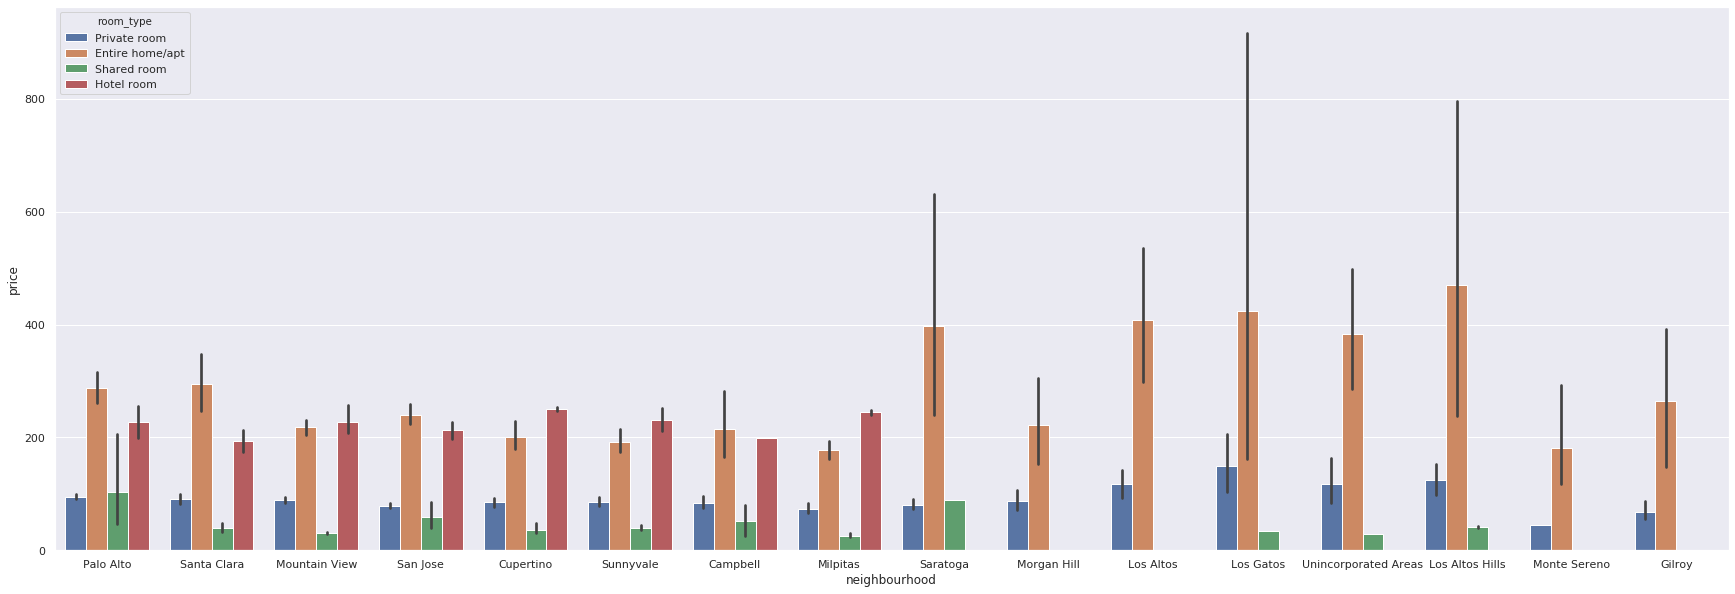

In [49]:
ax = sns.barplot(x="neighbourhood", y="price", hue="room_type", data=listings)
sns.set(rc={'figure.figsize':(25,10)})

# Trend around Reviews

[(736882.0, 737318.0)]

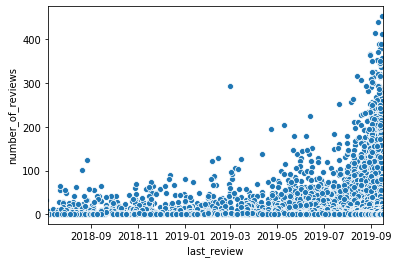

In [8]:
listings['last_review'] = pd.to_datetime(listings['last_review'], infer_datetime_format=True)
listings['last_review_month'] = pd.DatetimeIndex(listings['last_review']).month

ax = sns.scatterplot(x="last_review", y="number_of_reviews", data=listings)
ax.set(xlim=('2018-07-07', '2019-09-16'))

In [0]:
listings['last_review_month'] = pd.DatetimeIndex(listings['last_review']).month

ax = sns.scatterplot(x="last_review", y="number_of_reviews", data=listings)
ax.set(xlim=('2018-07-07', '2019-09-16'))

# Trend around Prices

[(0, 2000)]

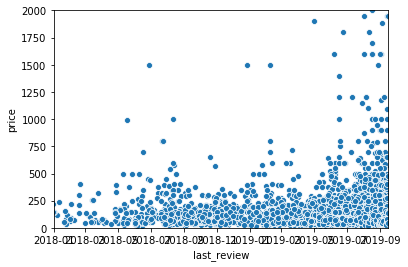

In [11]:
ax = sns.scatterplot(x="last_review", y="price", data=listings)
ax.set(xlim=('2018-01-01', '2019-09-16'))
ax.set(ylim=(0, 2000))

In [36]:
import plotly.express as px 

fig = px.scatter_mapbox(listings, lat="latitude", lon="longitude", hover_name="neighbourhood", hover_data=["price"], color='price', size='price',
                        zoom=3, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Price(the target) will need log transformation since its Right-Skewed

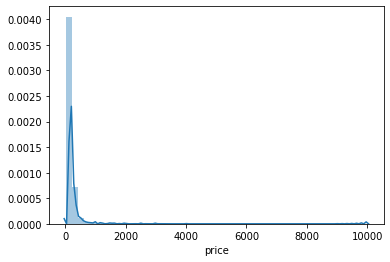

In [56]:
%matplotlib inline

sns.distplot(listings['price']);

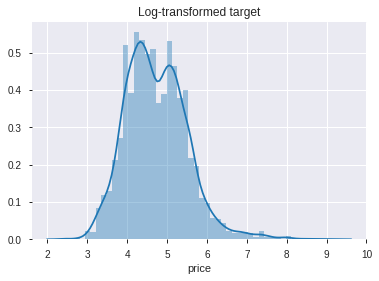

In [0]:
price_log = np.log1p(listings['price'])
sns.distplot(price_log)
plt.title('Log-transformed target'); # price here is log dollars

# Maybe even remove the outliers -??

In [0]:
listings = listings[(listings['price'] >= np.percentile(listings['price'], 0.5)) & 
        (listings['price'] <= np.percentile(listings['price'], 99.5)) & 
        (listings['latitude'] >= np.percentile(listings['latitude'], 0.05)) & 
        (listings['latitude'] < np.percentile(listings['latitude'], 99.95)) &
        (listings['longitude'] >= np.percentile(listings['longitude'], 0.05)) & 
        (listings['longitude'] <= np.percentile(listings['longitude'], 99.95))]

# Prepare to fit the model

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(listings, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [13]:
train.shape, val.shape, test.shape

((4758, 17), (1190, 17), (1487, 17))

In [69]:
# The status_group column is the target
target = 'price'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'neighbourhood_group'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'last_review_month', 'neighbourhood', 'room_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [39]:
#Baseline

y_pred = []

for x in range(1,len(y_val)+1):
  y_pred.append(listings['price'].mean())

print('MAE for RFR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for RFR: ', r2_score(y_val, y_pred))

MAE for RFR:  113.03038377422253
R2 Score for RFR:  -7.851197638464313e-06


In [22]:
#Linear Regression

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    LinearRegression()
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for LR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for LR: ', r2_score(y_val, y_pred))

MAE for LR:  75.67874760217376
R2 Score for LR:  0.10303235516615417


In [23]:
# Try Decision Tree [Seems to be the best]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(criterion='mse',max_depth=100)
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(mean_absolute_error(y_val, y_pred))
print('R2 Score for LR: ', r2_score(y_val, y_pred))

97.48235294117647
R2 Score for LR:  -0.14890727527918757


In [85]:
# Try Random Forest

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators= 500, random_state = 42)
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for RFR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for RFR: ', r2_score(y_val, y_pred))

MAE for RFR:  64.66059011050449


TypeError: ignored

In [41]:
# Using Gradient Boosting 

from xgboost import XGBRFRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRFRegressor(n_estimators=500, random_state=42, n_jobs=-1, objective ='reg:squarederror')
)

pipeline.fit(X_train, y_train)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for GB: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for GB: ', r2_score(y_val, y_pred))

MAE for GB:  74.65376544920336
R2 Score for GB:  0.11604884941434357


# Plot Feature importance using RandomForest Regressor

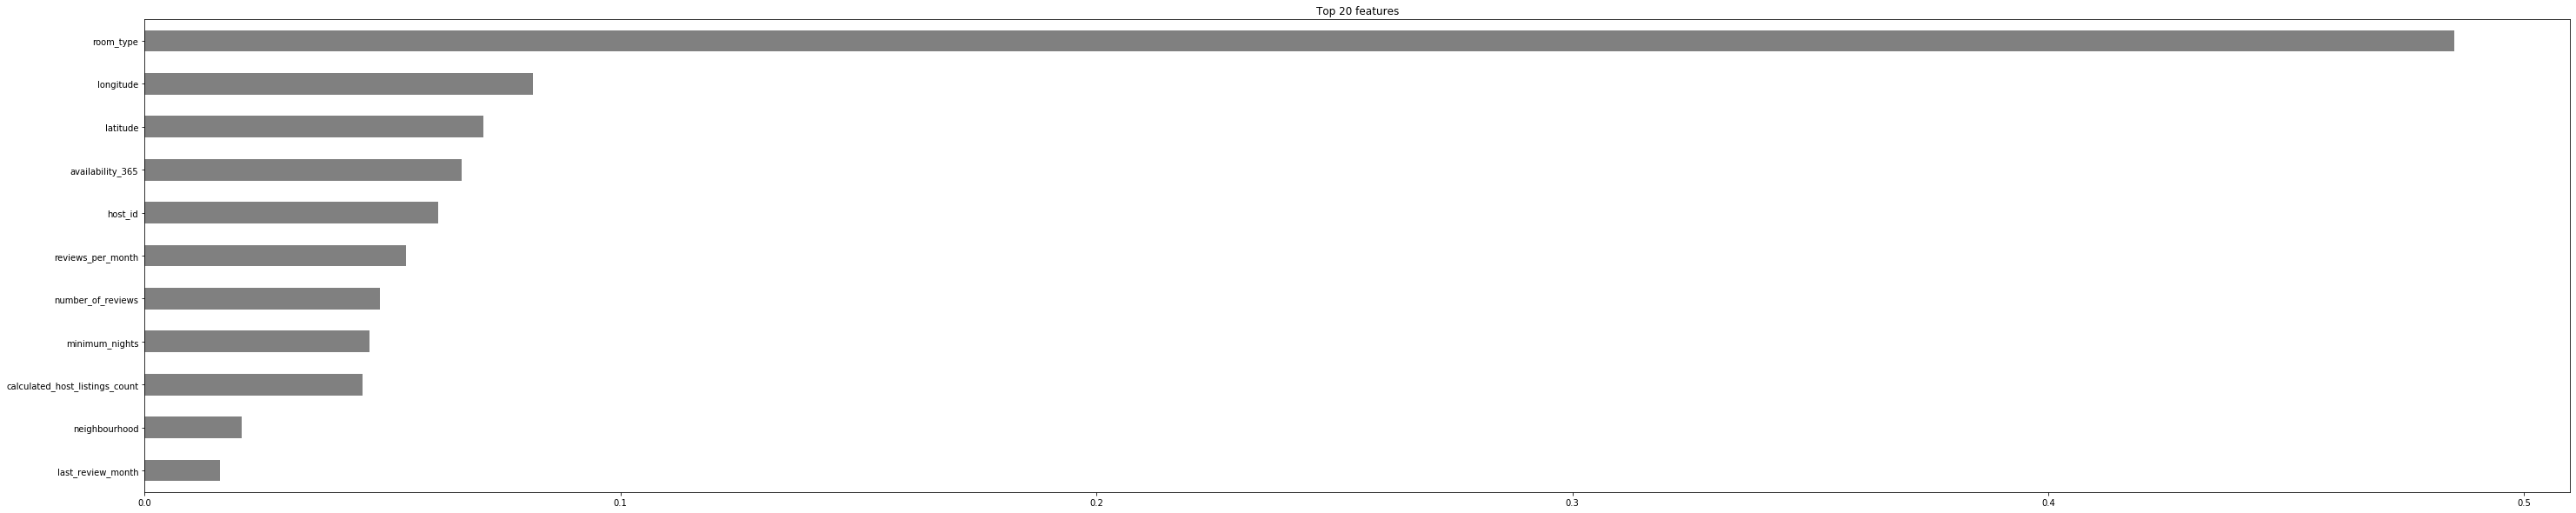

In [40]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(50,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# PDP visualization for Room Type

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


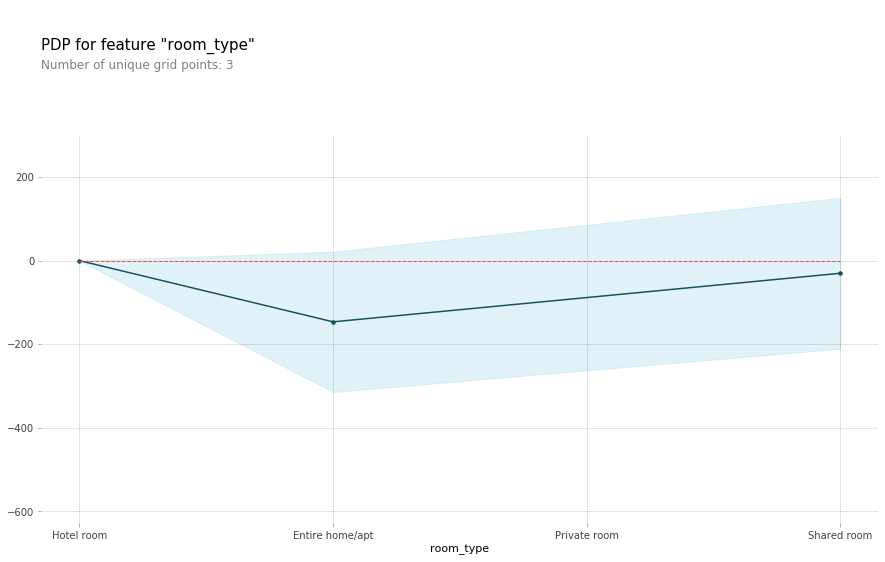

In [43]:
# Use Pdpbox - Automated version

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'room_type'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp_dist = pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']);

#PDP for another feature, "availability_365'

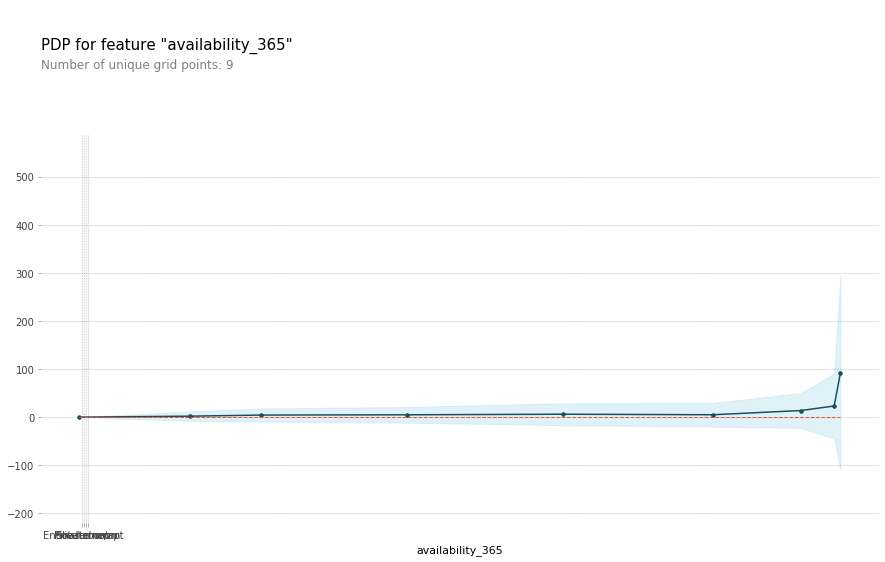

In [44]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'availability_365'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp_dist = pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']);

#PDP with 2 features (Room Type, Neighbourhood)

(None, <a list of 7 Text yticklabel objects>)

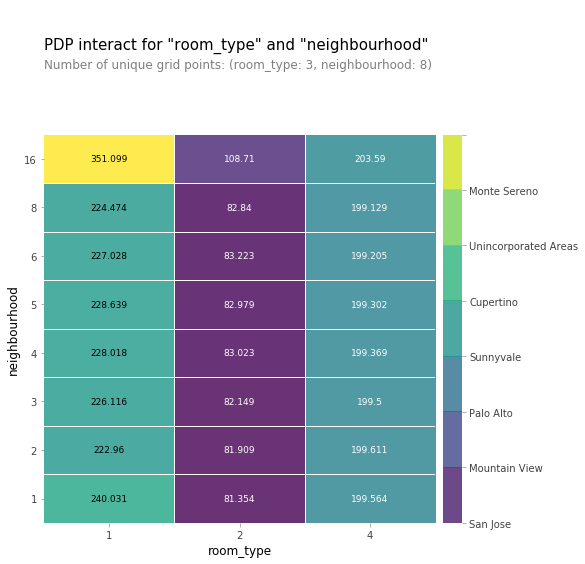

In [47]:
features = ['room_type', 'neighbourhood']

from pdpbox.pdp import pdp_interact_plot, pdp_interact

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'])

# Manually change the xticks labels


plt.yticks([1, 2, 3, 4, 5, 10, 16], ['San Jose', 'Mountain View', 'Palo Alto', 'Sunnyvale', 'Cupertino', 'Unincorporated Areas', 'Monte Sereno'])


# Feature Importance using ELI5 library

In [63]:
!pip install eli5

transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRFRegressor(
    n_estimators=1000, 
    max_depth=10, 
    objective='reg:squarederror', 
    n_jobs=-1, 
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=20)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', n_iter=3)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

[0]	validation_0-mae:58.4729	validation_1-mae:72.197
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.


Weight,Feature
54.7498 ± 3.1859,room_type
7.1514 ± 4.0310,availability_365
5.2661 ± 0.8660,minimum_nights
4.6382 ± 0.6345,calculated_host_listings_count
4.0531 ± 0.4242,longitude
3.6565 ± 1.6134,reviews_per_month
3.0862 ± 0.8564,number_of_reviews
2.4633 ± 1.6969,host_id
1.6937 ± 0.8185,neighbourhood
1.5268 ± 0.6230,latitude


In [0]:
X_train = X_train.replace(" ", "_")

In [55]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(300, 700), 
    'max_depth': [50, 100, 150, 200, None],
    'max_features': uniform(0, 1), 
}

transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
search.fit(X_train_transformed, y_train_log);


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.6min finished


In [56]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)


Best hyperparameters {'max_depth': None, 'max_features': 0.6011150117432088, 'n_estimators': 451}
Cross-validation MAE 0.3113199616490204


In [71]:
X_train.shape, X_test.shape

((4758, 11), (1487, 11))

In [74]:
pipeline = search.best_estimator_

transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

y_pred = pipeline.predict(X_test_transformed) 
mae = mean_absolute_error(y_test, y_pred) 
r2_score = r2_score(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')
print(f'R2 score: {r2_score}')

Test MAE: $154
R2 score: -0.32437749743860134
